In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["axes.grid"] = False
sc.settings.set_figure_params(dpi=80, dpi_save=180, vector_friendly=True, transparent=True) #for figures

#Read panNEC anndata: 
results= "./pnec_anndata_082023/pNEC_updated_annot_07082023.h5ad"
adata= sc.read_h5ad(results)

#Rename clusters:
adata.obs['Cell states'] = (adata.obs["Cell states"].map(lambda x: {"Neuroendocrine EEC-like01": "Amphicrine progenitor-like",
                    "Neuroendocrine EEC-like02": "Neuroendocrine",
                    "Neuroendocrine HSP+": "Neuroendocrine HSP+ (hypoxic)"}.get(x, x)).astype("category"))

adata.obs['Cell states'].cat.categories

Index(['Amphicrine acinar01', 'Amphicrine acinar02', 'Amphicrine acinar03',
       'Amphicrine acinar proliferating', 'Amphicrine progenitor-like',
       'Neuroendocrine', 'Neuroendocrine proliferating',
       'Neuroendocrine HSP+ (hypoxic)', 'Neuroendocrine stromal-like',
       'Stroma (normal)', 'Lymphocytes', 'Macrophages'],
      dtype='object')

In [2]:
import matplotlib.pyplot as plt

#Save original color mapping
original_colors = dict(zip(adata.obs['Cell states'].cat.categories, adata.uns['Cell states_colors']))
original_colors

{'Amphicrine acinar01': '#b3ccff',
 'Amphicrine acinar02': '#cc99ff',
 'Amphicrine acinar03': '#e6ccff',
 'Amphicrine acinar proliferating': '#3973ac',
 'Amphicrine progenitor-like': '#9999ff',
 'Neuroendocrine': '#00cccc',
 'Neuroendocrine proliferating': '#008080',
 'Neuroendocrine HSP+ (hypoxic)': '#004d4d',
 'Neuroendocrine stromal-like': '#4dffb8',
 'Stroma (normal)': '#ff99cc',
 'Lymphocytes': '#ff0000',
 'Macrophages': '#ff704d'}

In [3]:
#Define the new corrected order
desired_order = [
    #Shared
    "Neuroendocrine",
    "Neuroendocrine proliferating",
    "Neuroendocrine HSP+ (hypoxic)",
    "Neuroendocrine stromal-like",

    #Unique
    "Amphicrine acinar01",
    "Amphicrine acinar02",
    "Amphicrine acinar03",
    "Amphicrine acinar proliferating",
    "Amphicrine progenitor-like",

    #TME
    "Stroma (normal)",
    "Lymphocytes",
    "Macrophages"
]

#Ensure 'Cell states' is categorical with the correct order
adata.obs['Cell states'] = pd.Categorical(
    adata.obs['Cell states'],
    categories=desired_order,
    ordered=True
)

#Check if the order is applied
print(adata.obs['Cell states'].cat.categories)

Index(['Neuroendocrine', 'Neuroendocrine proliferating',
       'Neuroendocrine HSP+ (hypoxic)', 'Neuroendocrine stromal-like',
       'Amphicrine acinar01', 'Amphicrine acinar02', 'Amphicrine acinar03',
       'Amphicrine acinar proliferating', 'Amphicrine progenitor-like',
       'Stroma (normal)', 'Lymphocytes', 'Macrophages'],
      dtype='object')


<AxesSubplot:title={'center':'Cell states'}, xlabel='UMAP1', ylabel='UMAP2'>

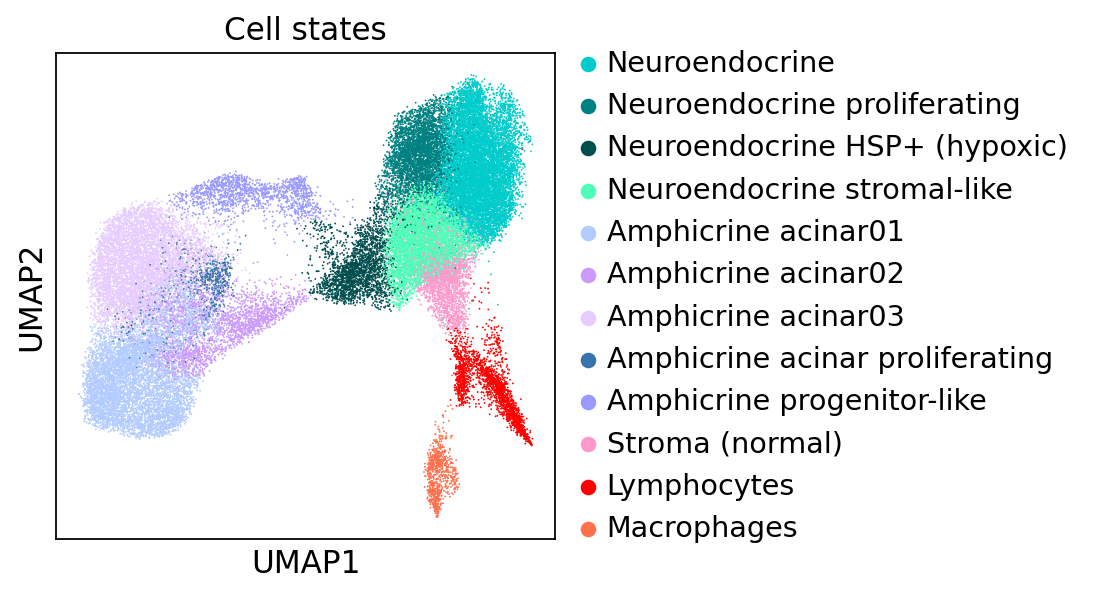

In [4]:
#Restore original colors in the correct order
adata.uns['Cell states_colors'] = [original_colors[cell] for cell in desired_order]

fig, ax = plt.subplots(figsize=(4,4))
sc.pl.umap(adata, color=['Cell states'], ax=ax, show=False)

In [5]:
#Normalize the data:
adata_norm= adata.raw.to_adata()
sc.pp.normalize_total(adata_norm, target_sum=1e4)
sc.pp.log1p(adata_norm)

[<AxesSubplot:title={'center':'EZH1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'EZH2'}, xlabel='UMAP1', ylabel='UMAP2'>]

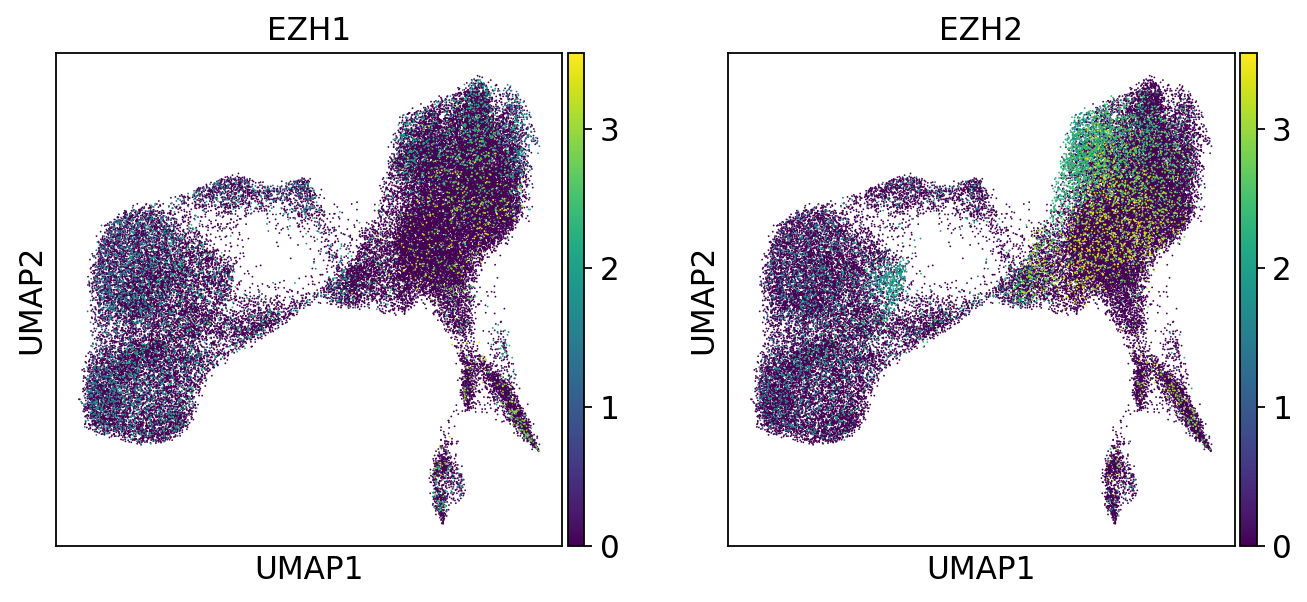

In [6]:
#Feature plot depicting EZH1 & EZH2 normalized expression: 
sc.pl.umap(adata_norm, color=['EZH1', 'EZH2'], show=False)

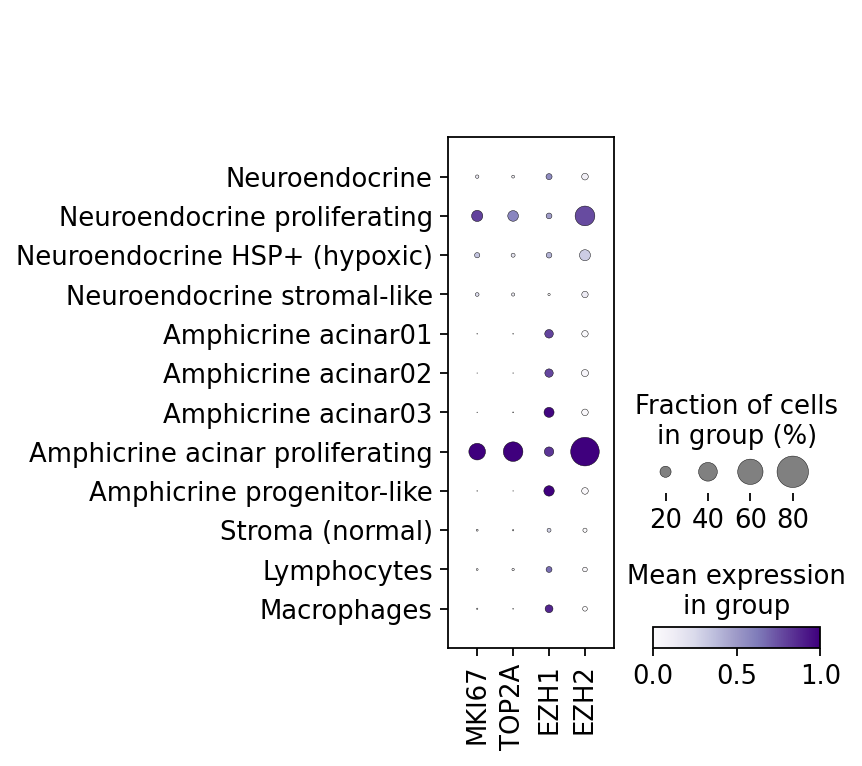

In [7]:
#Refine the colors: 
sc.pl.dotplot(adata_norm, ['MKI67', 'TOP2A', 'EZH1', 'EZH2'], groupby= 'Cell states', swap_axes=False,  
             cmap= "Purples", standard_scale="var")  

#EZH1 is relatively poorly expressed than EZH2- but it is important to know what percentage of cells co-express EZH1/EZH2. 

Given the clinical relevance of EZH2 inhibition in high-grade neuroendocrine neoplasms, we assessed the co-expression of EZH1 & EZH2 within NE-proliferating cells (EZH2 is a Logistic Regression inferred marker of NE prol) to evaluate potential compensatory mechanisms. Although EZH2 was broadly expressed, a small subpopulation also co-expressed EZH1, raising the possibility of functional PRC2 redundancy that could limit the efficacy of EZH2-targeted monotherapy.

In [8]:
#Remove the immune cells & subsequently, cells having InferCNV_counts==0 from pNET dataset: 
adata_norm= adata_norm[~adata_norm.obs['cell_states'].isin(['Lymphocytes (non-tumor)', 'Macrophages (non-tumor)'])] 
print(adata_norm.obs['Cell states'].cat.categories)

#Subset to shared clusters:
adata_norm= adata_norm[adata_norm.obs['Cell states'].isin(['Neuroendocrine', 'Neuroendocrine proliferating',
       'Neuroendocrine HSP+ (hypoxic)', 'Neuroendocrine stromal-like', 'Stroma (normal)'])] 

print(adata_norm.obs['Cell states'].value_counts())

Index(['Neuroendocrine', 'Neuroendocrine proliferating',
       'Neuroendocrine HSP+ (hypoxic)', 'Neuroendocrine stromal-like',
       'Amphicrine acinar01', 'Amphicrine acinar02', 'Amphicrine acinar03',
       'Amphicrine acinar proliferating', 'Amphicrine progenitor-like',
       'Stroma (normal)'],
      dtype='object')
Neuroendocrine                   10095
Neuroendocrine stromal-like       5668
Neuroendocrine proliferating      4033
Stroma (normal)                   2465
Neuroendocrine HSP+ (hypoxic)     2275
Name: Cell states, dtype: int64


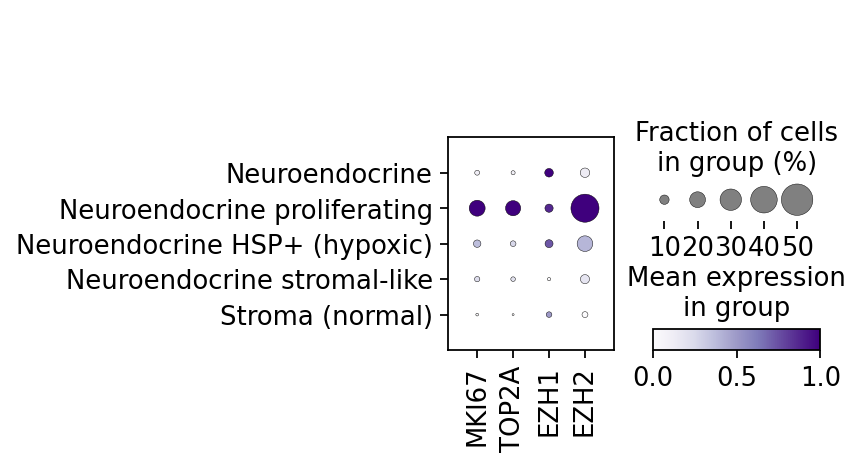

In [9]:
sc.pl.dotplot(adata_norm, ['MKI67', 'TOP2A', 'EZH1', 'EZH2'], groupby= 'Cell states', swap_axes=False,  
             cmap= "Purples", standard_scale="var", save= "__ExtdFig2H_EZH1_EZH2_11032025.pdf")

Although EZH1 expression was modest, its co-expression with EZH2 in the NE-proliferating state supports the rationale for dual PRC2 inhibition strategies, in line with prior studies highlighting EZH1-mediated compensation upon EZH2 blockade

In [10]:
adata_norm.uns['Cell states_colors']

array(['#00cccc', '#008080', '#004d4d', '#4dffb8', '#ff99cc'], dtype='<U7')

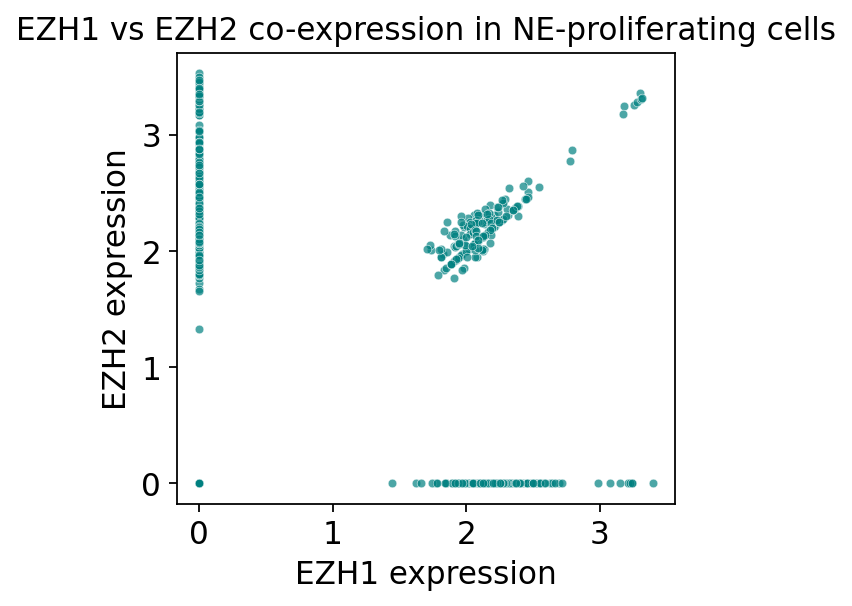

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Extract NE-proliferating mask
mask = adata_norm.obs['Cell states'] == 'Neuroendocrine proliferating'

#Get expression for EZH1 & EZH2 in NE-proliferating cells
ezh1_expr = adata_norm[mask, 'EZH1'].X.toarray().flatten()
ezh2_expr = adata_norm[mask, 'EZH2'].X.toarray().flatten()

#Use the same NE-prol color as in UMAP if you have a palette
ne_prol_color = '#008080'  

#Plot
plt.figure(figsize=(4, 4))
sns.scatterplot(x=ezh1_expr, y=ezh2_expr, s=15, alpha=0.7, color=ne_prol_color)
plt.xlabel('EZH1 expression')
plt.ylabel('EZH2 expression')
plt.title('EZH1 vs EZH2 co-expression in NE-proliferating cells')
plt.grid(False)  # remove grid
plt.tight_layout()
plt.show()

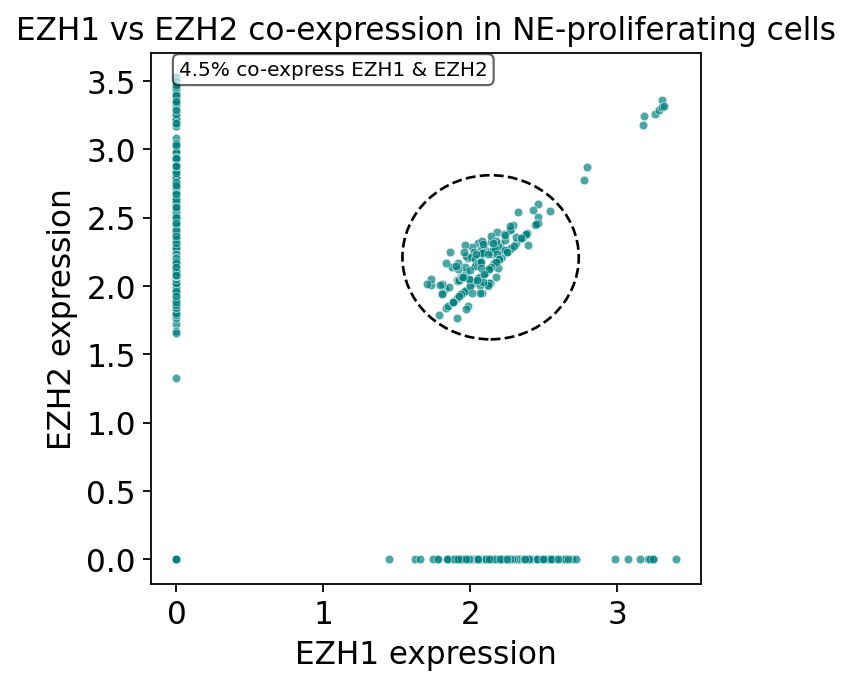

In [12]:
from matplotlib.patches import Ellipse

#Extract NE-proliferating mask
mask = adata_norm.obs['Cell states'] == 'Neuroendocrine proliferating'

#Get expression for EZH1 & EZH2
ezh1_expr = adata_norm[mask, 'EZH1'].X.toarray().flatten()
ezh2_expr = adata_norm[mask, 'EZH2'].X.toarray().flatten()

#Determine co-expression (non-zero for both)
co_expr_mask = (ezh1_expr > 0) & (ezh2_expr > 0)
percent_coexpr = np.sum(co_expr_mask) / len(ezh1_expr) * 100

#Plot
plt.figure(figsize=(4.5, 4.5))
sns.scatterplot(x=ezh1_expr, y=ezh2_expr, s=15, alpha=0.7, color='#008080')

#Circle around co-expressing cluster (you can tweak this)
circle = Ellipse(
    (np.mean(ezh1_expr[co_expr_mask]), np.mean(ezh2_expr[co_expr_mask])),
    width=1.2, height=1.2, edgecolor='black', facecolor='none', linestyle='--', linewidth=1.2
)
plt.gca().add_patch(circle)

#Text annotation for co-expression %
plt.text(
    0.05, 0.95,
    f'{percent_coexpr:.1f}% co-express EZH1 & EZH2',
    transform=plt.gca().transAxes,
    fontsize=9, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

plt.xlabel('EZH1 expression')
plt.ylabel('EZH2 expression')
plt.title('EZH1 vs EZH2 co-expression in NE-proliferating cells')
plt.grid(False)
plt.tight_layout()
plt.show()

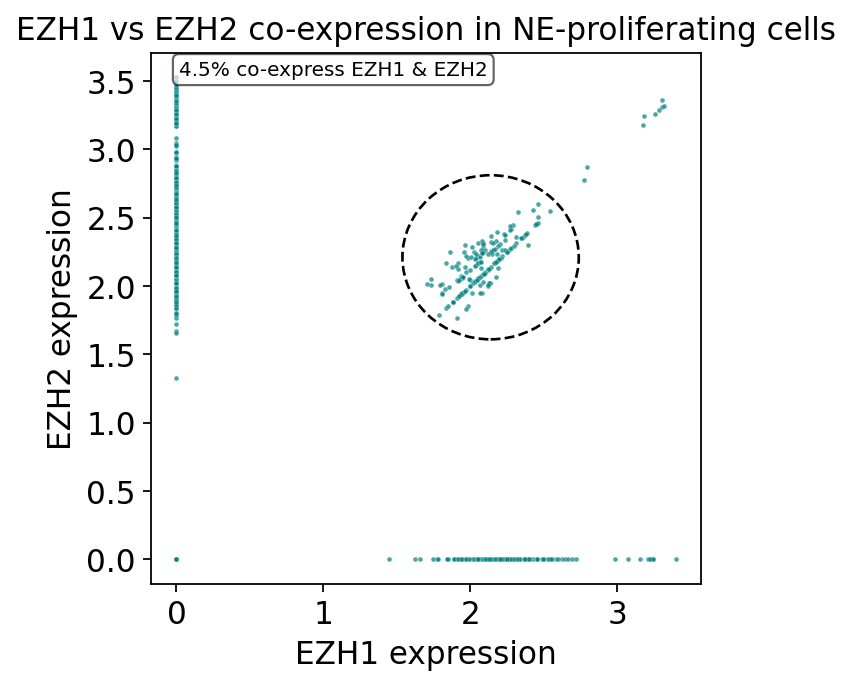

In [13]:
#Extract NE-proliferating mask
mask = adata_norm.obs['Cell states'] == 'Neuroendocrine proliferating'

#--- EZH1 vs EZH2 ---
ezh1_expr = adata_norm[mask, 'EZH1'].X.toarray().flatten()
ezh2_expr = adata_norm[mask, 'EZH2'].X.toarray().flatten()

co_expr_mask_1 = (ezh1_expr > 0) & (ezh2_expr > 0)
percent_coexpr_1 = np.sum(co_expr_mask_1) / len(ezh1_expr) * 100

plt.figure(figsize=(4.5, 4.5))
sns.scatterplot(x=ezh1_expr, y=ezh2_expr, s=5, alpha=0.7, color='#008080')

circle1 = Ellipse(
    (np.mean(ezh1_expr[co_expr_mask_1]), np.mean(ezh2_expr[co_expr_mask_1])),
    width=1.2, height=1.2, edgecolor='black', facecolor='none', linestyle='--', linewidth=1.2
)
plt.gca().add_patch(circle1)

plt.text(
    0.05, 0.95,
    f'{percent_coexpr_1:.1f}% co-express EZH1 & EZH2',
    transform=plt.gca().transAxes,
    fontsize=9, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

plt.xlabel('EZH1 expression')
plt.ylabel('EZH2 expression')
plt.title('EZH1 vs EZH2 co-expression in NE-proliferating cells')
plt.grid(False)
plt.tight_layout()
plt.savefig('_ExtdFigure2I_EZH1_EZH2_coexpression_11032025.pdf', dpi=600)
plt.show()
